In [225]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime



data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [226]:
def _encode_dates(X):
    X = X.copy()
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    return X

data = _encode_dates(data)

In [227]:
import holidays
vancances = holidays.CountryHoliday('France')

data["IsHolidays"] = data["date"].isin(vancances).astype(int)
data['IsWeekend'] = data['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [228]:
corr = data.select_dtypes('number').corr()
corr

,site_id,bike_count,latitude,longitude,log_bike_count,year,month,day,weekday,hour,IsHolidays,IsWeekend
site_id,1.000000,-0.003479,-0.129489,-0.188724,0.020998,0.084738,-0.061757,0.005179,0.000634,-0.000023,NaN,0.000466
bike_count,-0.003479,1.000000,0.131880,0.014581,0.738168,-0.017951,0.032669,-0.016421,-0.077352,0.131677,NaN,-0.098035
latitude,-0.129489,0.131880,1.000000,0.153856,0.113355,-0.010524,0.007317,-0.000195,-0.000103,-0.000013,NaN,-0.000025
longitude,-0.188724,0.014581,0.153856,1.000000,0.044494,-0.013599,0.008068,0.001530,-0.000190,-0.000016,NaN,0.000156
log_bike_count,0.020998,0.738168,0.113355,0.044494,1.000000,-0.005915,0.056814,-0.015934,-0.056230,0.273085,NaN,-0.081998
year,0.084738,-0.017951,-0.010524,-0.013599,-0.005915,1.000000,-0.794083,-0.025513,0.005834,-0.000521,NaN,0.007397
month,-0.061757,0.032669,0.007317,0.008068,0.056814,-0.794083,1.000000,-0.006185,-0.013164,0.000289,NaN,-0.014079
day,0.005179,-0.016421,-0.000195,0.001530,-0.015934,-0.025513,-0.006185,1.000000,0.012631,-0.000057,NaN,0.022498
weekday,0.000634,-0.077352,-0.000103,-0.000190,-0.056230,0.005834,-0.013164,0.012631,1.000000,0.000074,NaN,0.790371
hour,-0.000023,0.131677,-0.000013,-0.000016,0.273085,-0.000521,0.000289,-0.000057,0.000074,1.000000,NaN,0.000153


<Axes: >

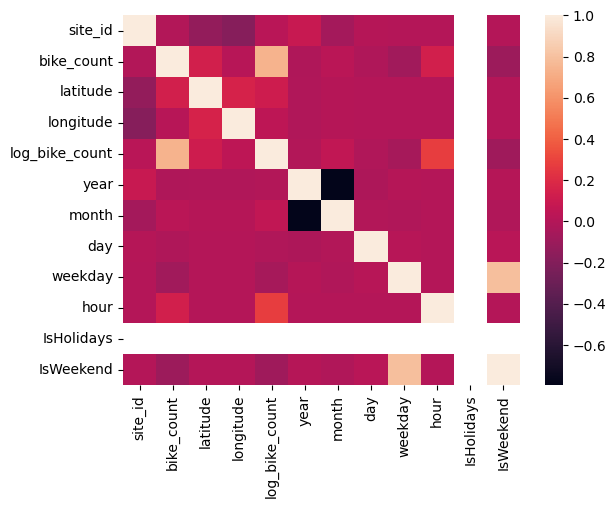

In [229]:
sns.heatmap(corr)

On ne tire pas grand chose de cette régresion... bike_count et log_bike_count ne s'expliquent pas directement grace à une autre variable numérique (on pouvait s'y attendre...).

# Data analysis

Moyenne par heure par jour

<Figure size 1000x600 with 0 Axes>

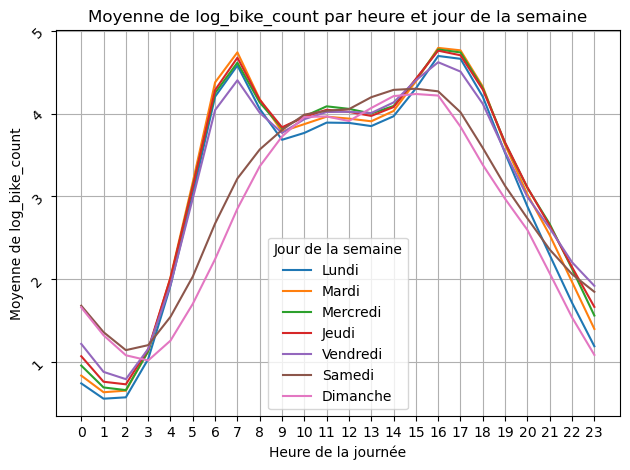

In [230]:

group1 = data.groupby(['weekday', 'hour'])['log_bike_count'].mean().unstack()

plt.figure(figsize=(10, 6))

group1.T.plot()

plt.title('Moyenne de log_bike_count par heure et jour de la semaine')
plt.xlabel('Heure de la journée')
plt.ylabel('Moyenne de log_bike_count')
plt.xticks(range(0, 24))
plt.yticks(rotation=45)
plt.legend(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'], title='Jour de la semaine')

plt.grid(True)
plt.tight_layout()
plt.show()


On observe une différence notable entre jours de la semaine et week-end

<Figure size 1400x800 with 0 Axes>

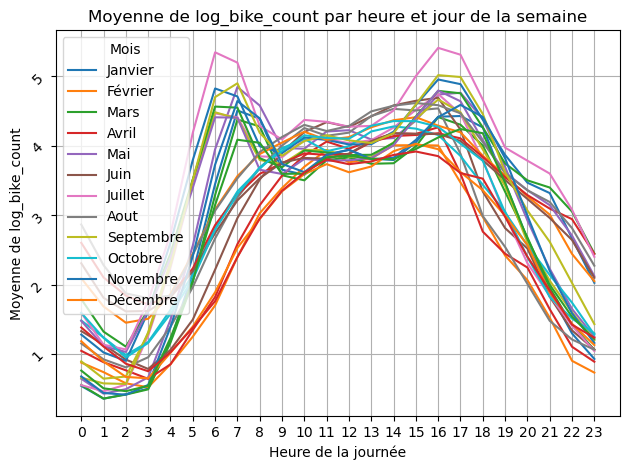

In [234]:
group2 = data.groupby(['month','IsWeekend', 'hour'])['log_bike_count'].mean().unstack()

plt.figure(figsize=(14, 8))

group2.T.plot()

plt.title('Moyenne de log_bike_count par heure et jour de la semaine')
plt.xlabel('Heure de la journée')
plt.ylabel('Moyenne de log_bike_count')
plt.xticks(range(0, 24))
plt.yticks(rotation=45)
plt.legend(['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre'], title='Mois')

plt.grid(True)
plt.tight_layout()
plt.show()


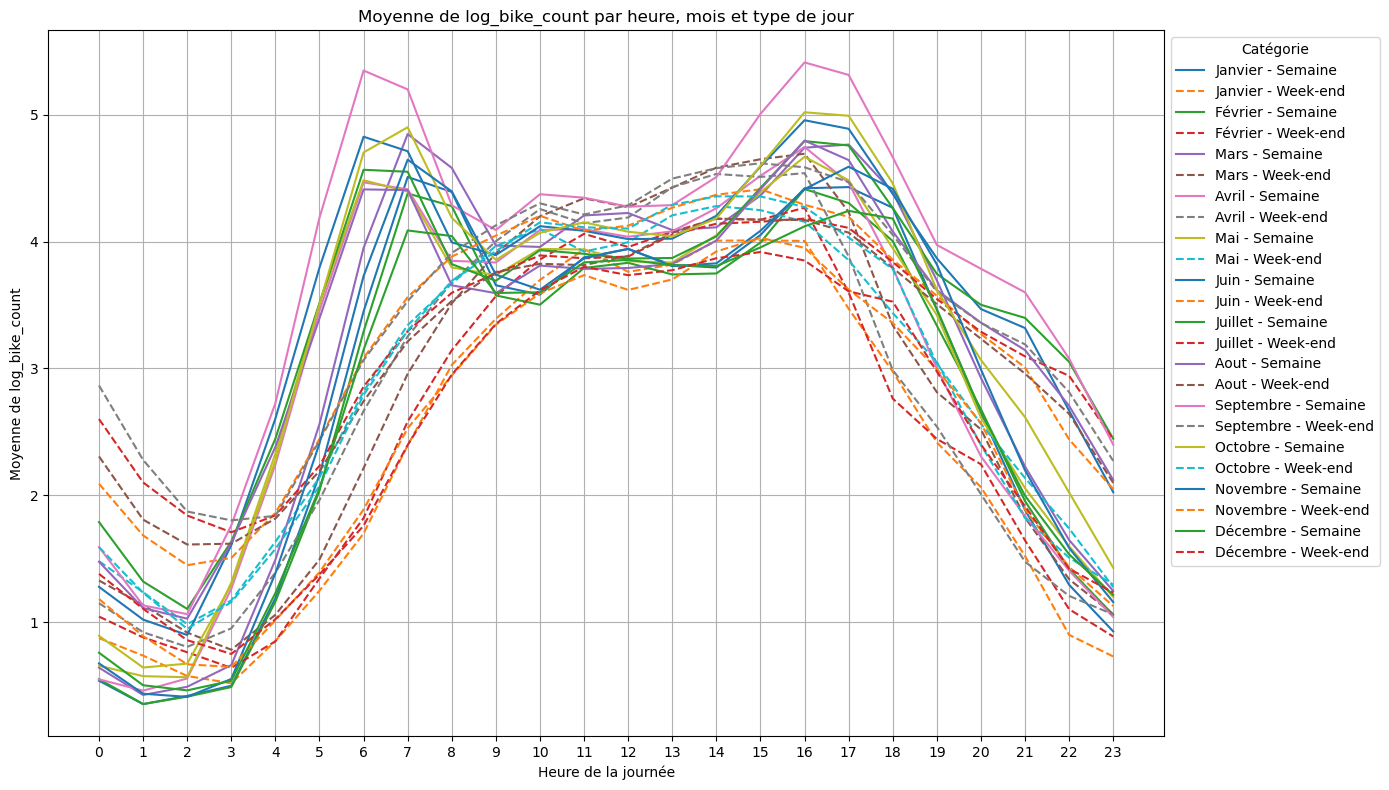

In [236]:
group2 = data.groupby(['month', 'IsWeekend', 'hour'])['log_bike_count'].mean()

plt.figure(figsize=(14, 8))

months = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 
          'Juillet', 'Aout', 'Septembre', 'Octobre', 'Novembre', 'Décembre']

for month_index in range(1, 13):
    weekday_data = group2.loc[month_index, 0]
    weekend_data = group2.loc[month_index, 1]
    
    plt.plot(weekday_data.index, weekday_data.values, label=f'{months[month_index - 1]} - Semaine')
    plt.plot(weekend_data.index, weekend_data.values, '--', label=f'{months[month_index - 1]} - Week-end')

plt.title('Moyenne de log_bike_count par heure, mois et type de jour')
plt.xlabel('Heure de la journée')
plt.ylabel('Moyenne de log_bike_count')
plt.xticks(range(0, 24))
plt.legend(title='Catégorie', loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

plt.show()


Différence notable entre semaine et week-end

In [ ]:
def 